# [1] WNS Analytics Wizard

## [2] Importing important libraries:

In [4]:
import numpy as np
import pandas as pd
import dask.dataframe as ddf
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from wordcloud import WordCloud,STOPWORDS


from collections import defaultdict
from collections import Counter 
from scipy.sparse import hstack
import operator

from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN, SMOTENC, SVMSMOTE
from kmeans_smote import KMeansSMOTE
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

from bayes_opt import BayesianOptimization

import re
import string #for text pre-processing
import pickle

import warnings
warnings.filterwarnings("ignore")

import gc #Garbage collector.

In [2]:
import tensorflow as tf

In [3]:
import sklearn
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, make_scorer, cohen_kappa_score, roc_auc_score, confusion_matrix

from sklearn.metrics import precision_recall_curve, auc, roc_curve, hamming_loss, log_loss, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

<h4> Settings for Pandas, Seaborn, CPU/GPU usage </h4>

In [5]:
tqdm.pandas()
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
sns.set(rc={'figure.figsize':(10, 5)})

In [6]:
pd.options.display.max_columns=50
pd.options.display.max_rows=100

### Data Dictionary:

#### Train:

| Variable                | Description       |
|-------------------------|-------------------|
|impression_id|	AD impression id
|impression_time|	Time of the impression at partner website
|user_id|	user id
|app_code|	Application Code for a partner website where the ad was shown
|os_version|	Version of operating system
|is_4G|	1-Using 4G, 0-No 4G
|is_click|	(target) Whether user clicked the AD (1-click, 0-no click)

#### view_log:

| Variable                | Description       |
|-------------------------|-------------------|
|server_time	|Timestamp of the log
|device_type	|Device type of the user
|session_id	|Browser session id
|user_id	|user id
|item_id	|Item id

#### item_data:

| Variable                | Description       |
|-------------------------|-------------------|
|item_id	|Item id
|item_price	|Price of the item
|category_1	|Category depth 1
|category_2	|Category depth 2
|category_3	|Category depth 3
|product_type	|anonymized item type


## [3] Reading data and basic stats:

In [5]:
#Presseting all the num features as 'uint16' or 'uint8' to reduce memmory usage.
Presetting = True
train_dtypes = {
        'user_id'       : 'uint32',
        'app_code'      : 'uint16',
        'is_4G'         : 'uint8',
        'is_click'      : 'uint8',
        }

test_dtypes = {
        'user_id'       : 'uint32',
        'app_code'      : 'uint32',
        'is_4G'         : 'uint8'
        }

view_log_dtypes = {
        'session_id'    : 'uint32',
        'user_id'       : 'uint32',
        'item_id'       : 'uint32'
        }

item_data_dtypes = {
        'item_id'       : 'uint32',
        'item_price'    : 'int32',  #Only keeping the item_price as int32 so that we don't loose rows having -ve price.
        'category_1'    : 'uint16',
        'category_2'    : 'uint16',
        'category_3'    : 'uint16',
        'product_type'  : 'uint32'
        }

if Presetting:
    train = pd.read_csv("train.csv",dtype=train_dtypes)
    view_log = pd.read_csv("view_log.csv",dtype=view_log_dtypes)
    item_data = pd.read_csv("item_data.csv",dtype=item_data_dtypes)
    test = pd.read_csv("test.csv",dtype=test_dtypes)
else:
    train = pd.read_csv("train.csv")
    view_log = pd.read_csv("view_log.csv")
    item_data = pd.read_csv("item_data.csv")
    test = pd.read_csv("test.csv")

print("Number of data points in Train:",train.shape[0])
print("Number of data points in view_log:",view_log.shape[0])
print("Number of data points in item_data:",item_data.shape[0])
print("Number of data points in Test:",test.shape[0])

print(train.info())
print(view_log.info())
print(item_data.info())
print(test.info())

Number of data points in Train: 237609
Number of data points in view_log: 3118622
Number of data points in item_data: 132761
Number of data points in Test: 90675
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
impression_id      237609 non-null object
impression_time    237609 non-null object
user_id            237609 non-null uint32
app_code           237609 non-null uint16
os_version         237609 non-null object
is_4G              237609 non-null uint8
is_click           237609 non-null uint8
dtypes: object(3), uint16(1), uint32(1), uint8(2)
memory usage: 7.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3118622 entries, 0 to 3118621
Data columns (total 5 columns):
server_time    object
device_type    object
session_id     uint32
user_id        uint32
item_id        uint32
dtypes: object(2), uint32(3)
memory usage: 83.3+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132761 entries, 0 to 132760
Da

## [4] Exploratory Data Analysis:

In [6]:
#Checking for duplicates.
print(train.duplicated(keep = False).any())
print(test.duplicated(keep = False).any())

False
False


In [7]:
train['impression_time'] = pd.to_datetime(train['impression_time'])
test['impression_time'] = pd.to_datetime(test['impression_time'])

- 'impression_time' for Train is from 2018-11-15 00:00:00 to 2018-12-13 07:43:00.
- 'impression_time' for Train is from 2018-12-13 07:44:00 to 2018-12-18 23:59:00.

In [8]:
#Checking for duplicates. Duplicates are present for the below combination of columns.
train[train[['impression_time','user_id','app_code', 'os_version']].duplicated(keep=False)].iloc[16:20]

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
30856,882a81b2869854538c5e3c5d3188a0ba,2018-11-20 22:43:00,1438,37,intermediate,1,0
32300,512b64c840510a6f1f1d01c98b010148,2018-11-17 02:08:00,12053,371,latest,1,0
33049,775a90dc133a5870654dc448e95ce41b,2018-11-17 18:19:00,71440,296,old,1,0
35624,77b1932b3eec9f094a2b103001f0dff1,2018-11-17 18:19:00,71440,296,old,1,0


**Duplicate columns example:-**

- 33049	775a90dc133a5870654dc448e95ce41b	2018-11-17 18:19:00	71440	296	old	1	0
- 35624	77b1932b3eec9f094a2b103001f0dff1	2018-11-17 18:19:00	71440	296	old	1	0

Only Impression_id is unique which means prediction will the same for both of these 2 rows.

In [9]:
#Checking for duplicates. Duplicates are present for the below combination of columns.
test[test[['impression_time','user_id','app_code', 'os_version']].duplicated(keep=False)].head(5)

,impression_id,impression_time,user_id,app_code,os_version,is_4G
233,3b76f5a83fe627c7006bcfd746df07af,2018-12-13 08:44:00,4255,111,old,0
774,fcf083b42144215069547b626f694a6a,2018-12-13 00:02:00,75148,190,old,0
896,0bf6a4a6b94ba1ef79b9934b744edc72,2018-12-13 00:34:00,89496,127,intermediate,0
1609,c7ca350ef0bb656a7ea6d9446781ce94,2018-12-12 21:56:00,15812,504,latest,0
1610,062b3454bcd3c3dbfe461d04773d8054,2018-12-12 21:56:00,15812,504,latest,0


**Duplicate columns example:-**

- 1609	c7ca350ef0bb656a7ea6d9446781ce94	2018-12-12 21:56:00	15812	504	latest	0
- 1610	062b3454bcd3c3dbfe461d04773d8054	2018-12-12 21:56:00	15812	504	latest	0

Only Impression_id is unique.

In [10]:
print("no. of unique user_id  = ", train['user_id'].nunique())
print("no. of unique app_code = ", train['app_code'].nunique())
print("no. of unique user_id  = ", test['user_id'].nunique())
print("no. of unique app_code = ", test['app_code'].nunique())

no. of unique user_id  =  74723
no. of unique app_code =  490
no. of unique user_id  =  34079
no. of unique app_code =  373


In [11]:
view_log.head(2)

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640


In [12]:
print("no. of unique session_id  = ", view_log['session_id'].nunique())
print("no. of unique user_id     = ", view_log['user_id'].nunique())
print("no. of unique item_id     = ", view_log['item_id'].nunique())

no. of unique session_id  =  1014970
no. of unique user_id     =  89157
no. of unique item_id     =  126708


In [13]:
item_data.head(2)

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822


In [14]:
print("no. of unique item_id       = ", item_data['item_id'].nunique())
print("no. of unique product_type  = ", item_data['product_type'].nunique())

no. of unique item_id       =  132761
no. of unique product_type  =  7959


In [15]:
#Merging train with view_log and item_data.
train_data = pd.merge(train, view_log, on='user_id', how='inner')
#Left joining so that we dont exclude any user_id from train
train_data = pd.merge(train_data, item_data, on='item_id', how='left')

<h5> !! Run this cell only once for double inner joins </h5>

Checking whether all the user_ids have their log data in view_log and item data in item_data.
We can get this only by inner joining train with view_log then inner join with item_data.

set(train['user_id'].unique()).difference(set(train_data['user_id'].unique()))

**{27059, 87364}**

In [16]:
#Columns for median imputation.
cols = ['item_price', 'category_1', 'category_2', 'category_3']

#Choosing only those user_ids that are present in train but not present in train_data.
#Imputing Nan values with median from item_data[col] as they have outliers.
for col in cols:
    train_data[col][train_data['user_id'].isin([27059, 87364])] = \
                        train_data[col][train_data['user_id'].isin([27059, 87364])]\
                        .fillna(int(item_data[col].median()), inplace=False)
#For 'product_type' imputing mode.
train_data['product_type'][train_data['user_id'].isin([27059, 87364])] = \
                        train_data['product_type'][train_data['user_id']
                        .isin([27059, 87364])]\
                        .fillna(item_data['product_type'].mode()[0], inplace=False)

In [17]:
train_data[train_data['user_id'].isin([27059, 87364])].fillna(int(item_data['product_type'].mode()))

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,server_time,device_type,session_id,item_id,item_price,category_1,category_2,category_3,product_type
3502113,d41ca4d10ddfea76d016acbfded20618,2018-11-18 14:12:00,87364,127,intermediate,0,0,2018-10-18 18:51:00,android,919191,19919,2944.0,9.0,40.0,159.0,2874.0
3502114,054feb2acfd28eeca93f8f22e35cc6d1,2018-11-18 21:31:00,87364,127,intermediate,1,0,2018-10-18 18:51:00,android,919191,19919,2944.0,9.0,40.0,159.0,2874.0
10830394,8a63815dd378b44c1f8583deb7d4d038,2018-12-10 21:14:00,27059,372,intermediate,0,0,2018-12-10 13:45:00,android,878529,62896,2944.0,9.0,40.0,159.0,2874.0


In [18]:
print("no. of rows with Nan",len(train_data[train_data.isna().any(axis=1)]))
train_data = train_data.dropna()  #.reset_index(drop=True) #Resetting index 
print("Final no. of rows in Train",train_data.shape[0])

no. of rows with Nan 6840
Final no. of rows in Train 11046042


In [19]:
#Merging test with view_log and item_data.
test_data = pd.merge(test, view_log, on='user_id', how='inner')
#Left joining so that we dont exclude any user_id from test.
test_data = pd.merge(test_data, item_data, on='item_id', how='left')

<h5> !! Run this cell only once for double inner joins </h5>

user_ids in the view_log whose item_id is not present in the item_data.
We can get this only by inner joining test with view_log then inner join with item_data.
set(test['user_id'].unique()).difference(set(test_data['user_id'].unique()))

**{16330, 39804, 64781}**

In [20]:
#Columns for median imputation.
cols = ['item_price', 'category_1', 'category_2', 'category_3']

#Choosing only those user_ids that are present in test but not present in test_data.
#Imputing Nan values with median from item_data[col] as they have outliers.
for col in cols:
    test_data[col][test_data['user_id'].isin([16330, 39804, 64781])] = \
                        test_data[col][test_data['user_id'].isin([16330, 39804, 64781])]\
                        .fillna(int(item_data[col].median()), inplace=False)
#For 'product_type' imputing mode.
test_data['product_type'][test_data['user_id'].isin([16330, 39804, 64781])] = \
                        test_data['product_type'][test_data['user_id']
                        .isin([16330, 39804, 64781])]\
                        .fillna(item_data['product_type'].mode()[0], inplace=False)

In [22]:
test_data[test_data['user_id'].isin([16330, 39804, 64781])].fillna(int(item_data['product_type'].mode()))

,impression_id,impression_time,user_id,app_code,os_version,is_4G,server_time,device_type,session_id,item_id,item_price,category_1,category_2,category_3,product_type
1795906,68bafb0b05504c099736b33cbf378f31,2018-12-14 12:45:00,16330,296,old,0,2018-11-18 10:50:00,android,34112,72294,2944.0,9.0,40.0,159.0,2874.0
2428253,2cc63a4e1d43b1c40d100d7e040176a8,2018-12-13 01:02:00,64781,371,latest,0,2018-11-19 01:44:00,android,790854,72294,2944.0,9.0,40.0,159.0,2874.0
3217655,f15ad4a0bea1bbbd5cc5611b61d8e55e,2018-12-16 00:47:00,39804,250,latest,0,2018-11-02 02:07:00,android,703062,62896,2944.0,9.0,40.0,159.0,2874.0


In [23]:
print("no. of rows with Nan",len(test_data[test_data.isna().any(axis=1)]))
test_data = test_data.dropna()
print("Final no. of rows in test",test_data.shape[0])

no. of rows with Nan 2414
Final no. of rows in test 3869283


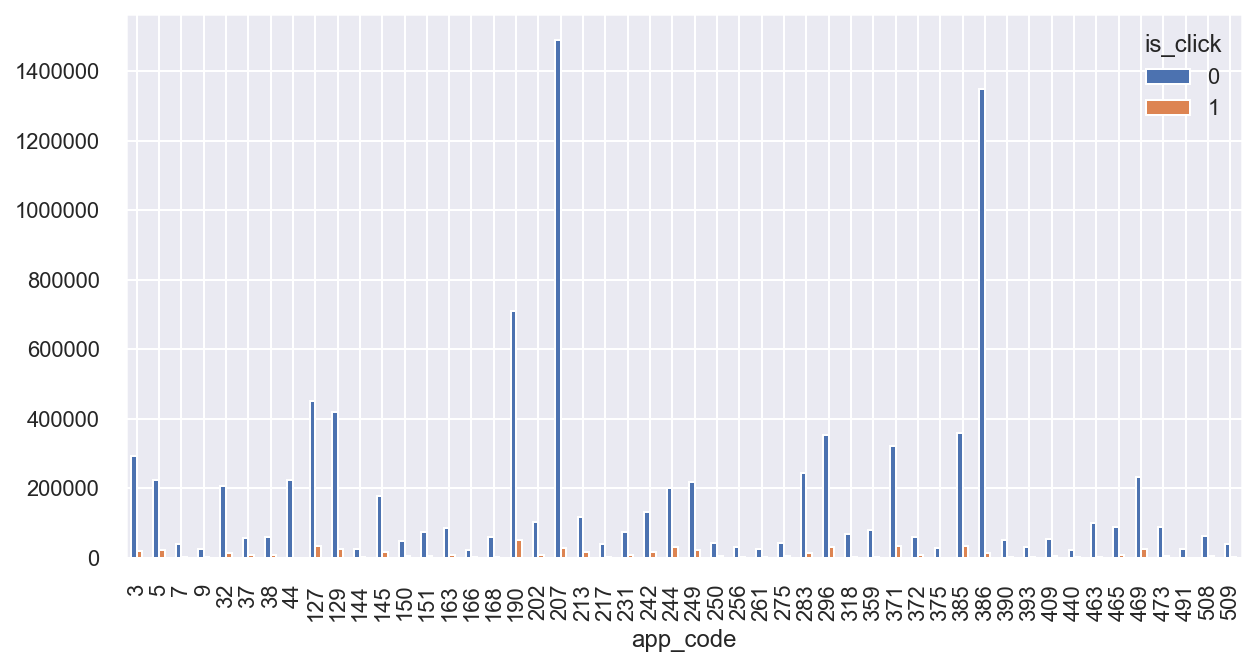

In [145]:
#Plotting stack plot for Top n most frequent points.
col = 'app_code'
top_most_freq = [Counter(train_data[col]).most_common(50)[i][0] for i in range(50)]
pd.crosstab(train_data[col][train_data[col].isin(top_most_freq)],
                train_data['is_click'][train_data[col].isin(top_most_freq)]).plot(kind='bar',sort_columns=True)

- app_code 127, 190, 244, 296, 371, 385, 469 have high ratio of clicks/CTR.

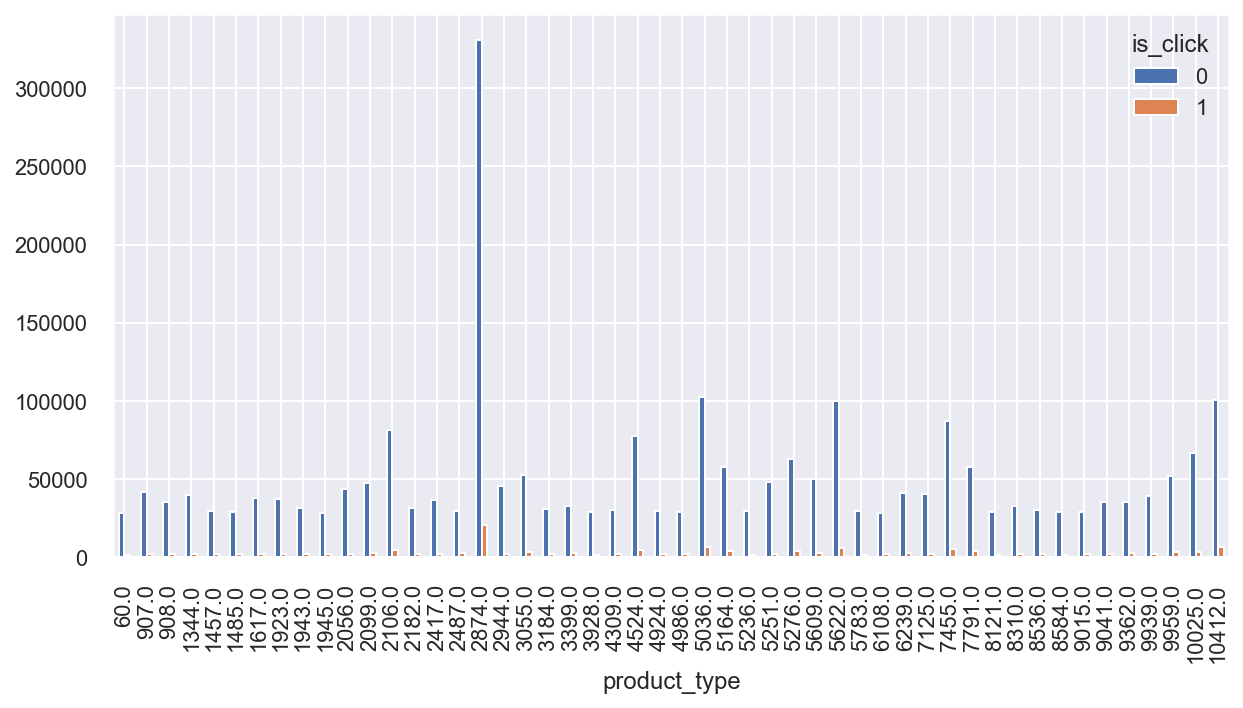

In [147]:
#Plotting stack plot for Top n most frequent points.
col = 'product_type'
top_most_freq = [Counter(train_data[col]).most_common(50)[i][0] for i in range(50)]
pd.crosstab(train_data[col][train_data[col].isin(top_most_freq)],
                train_data['is_click'][train_data[col].isin(top_most_freq)]).plot(kind='bar',sort_columns=True)

- product_type 2106, 2874, 4524, 5036, 5622, 10412 have high ratio of clicks/CTR.

In [25]:
#Also converting id columns to categorical.
cols = set(train_data.columns) - set(['impression_time','server_time','item_price', 'is_click'])
for col in cols:
    train_data[col] = train_data[col].astype('object')
    test_data[col] = test_data[col].astype('object')

## [5] Feature engineering:

<h5> Lets find out how different are train_data Ids and test_data Ids. </h5>

In [26]:
#%%time   #with .unique() this cell runs much faster compared to without it.
print("Difference in user_id- ",len(set(train_data['user_id'].unique()).difference(set(test_data['user_id'].unique()))))
print("Difference in session_id- ",len(set(train_data['session_id'].unique()).difference(set(test_data['session_id'].unique()))))
print("Difference in item_id- ",len(set(train_data['item_id'].unique()).difference(set(test_data['item_id'].unique()))))
print("Difference in product_type- ",len(set(train_data['product_type'].unique()).difference(set(test_data['product_type'].unique()))))
print("Difference in app_code- ",len(set(train_data['app_code'].unique()).difference(set(test_data['app_code'].unique()))))

Difference in user_id-  55078
Difference in session_id-  583648
Difference in item_id-  47687
Difference in product_type-  1032
Difference in app_code-  149


- We will be dropping Id columns as they too different in Train and Test.

In [27]:
columns_to_drop = ['impression_time','server_time','user_id','session_id']
train_data = train_data.drop(columns_to_drop,1)
test_data = test_data.drop(columns_to_drop,1)

In [28]:
cat_columns = train_data.select_dtypes(include='object').columns.to_list()
print(cat_columns)

['impression_id', 'app_code', 'os_version', 'is_4G', 'device_type', 'item_id', 'category_1', 'category_2', 'category_3', 'product_type']


In [29]:
#Removing duplicates
train_data = train_data[train_data.duplicated(keep='first')==False].reset_index(drop=True)
test_data = test_data[test_data.duplicated(keep='first')==False]#.reset_index(drop=True)

In [30]:
y_true = train_data['is_click']

In [73]:
train_data[train_data['is_click']==1].groupby(cat_columns).agg(['mean'])

is_click  \
                                                                                                                           mean   
impression_id                    app_code os_version   is_4G device_type category_1 category_2 category_3 product_type            
0011e2df40eee5989c7cb95aeb694881 381      latest       0     android     1.0        42.0       157.0      5208.0              1   
                                                                         4.0        74.0       292.0      332.0               1   
                                                                         7.0        72.0       79.0       6367.0              1   
                                                                         9.0        9.0        244.0      2106.0              1   
                                                                                    66.0       255.0      5655.0              1   
                                                                         10.0       43.0       223.0      1743.0              1   
                                                                         11.0       35.0       148.0      4153.0              1   
                                                                         12.0       30.0       331.0      7998.0              1   
                                                                         13.0       58.0       75.0       7774.0              1   
                                                                         17.0       8.0        113.0      4757.0              1   
                                                                                    39.0       151.0      9244.0              1   
                                                                                                          9628.0              1   
00126b47d5502dfb7d01f750ad23d813 207      latest       1     android     0.0        6.0        50.0       462.0               1   
                                                                                    45.0       73.0       3349.0              1   
                                                                                               320.0      4422.0              1   
                                                                         1.0        36.0       28.0       4646.0              1   
                                                                                    42.0       30.0       2412.0              1   
                                                                         4.0        38.0       62.0       7284.0              1   
                                                                                                          7632.0              1   
                                                                         9.0        3.0        27.0       9079.0              1   
                                                                                    44.0       114.0      5236.0              1   
                                                                         10.0       63.0       216.0      1293.0              1   
                                                                         11.0       51.0       290.0      3844.0              1   
                                                                         12.0       57.0       184.0      9458.0              1   
                                                                         13.0       67.0       32.0       6423.0              1   
                                                                         14.0       29.0       199.0      3930.0              1   
                                                                                    62.0       333.0      6693.0              1   
                                                                         16.0       4.0        119.0      4735.0              1   
                                                          

- For every impression_id there a unique app_code, os_version, is_4G, device_type.

In [32]:
train_data = train_data.drop(['is_click'],1) #Removing label is_click for feature engg.

<h4>  Target mean encoding </h4> 

In [33]:
#Credits: https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features
def add_noise(series, noise_level):
    return series * (1 + noise_level * np.random.randn(len(series)))
def target_encode(trn_series=None, 
                  tst_series=None, 
                  target=None, 
                  min_samples_leaf=1, 
                  smoothing=1,
                  noise_level=0):
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    # Compute target mean 
    averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
    # Compute smoothing
    smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
    # Apply average function to all target data
    prior = target.mean()
    # The bigger the count the less full_avg is taken into account
    averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
    averages.drop(["mean", "count"], axis=1, inplace=True)
    # Apply averages to trn and tst series
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge does not keep the index so restore it
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [34]:
%%time
cols = cat_columns[1:]
for col in cols:
    train_data[col], test_data[col] = target_encode(train_data[col], 
                                      test_data[col], 
                                      target=y_true, 
                                      min_samples_leaf=10,
                                      smoothing=10,
                                      noise_level=0.01)

Wall time: 37.7 s


In [114]:
#train_data['app_code_weighted'] = 2*(train_data['app_code']+10)
train_data['app_code|product_type'] = train_data['app_code']+train_data['product_type']
train_data['app_code_and_product_type'] = (train_data['app_code']+5000)*(train_data['product_type']+1) #More weight to app_code
train_data['price_by_app_code|product_type'] = train_data['item_price']/(train_data['app_code|product_type']+1)

#test_data['app_code_weighted'] = 2*(test_data['app_code']+10)
test_data['app_code|product_type'] = test_data['app_code']+train_data['product_type']
test_data['app_code_and_product_type'] = (test_data['app_code']+5000)*(test_data['product_type']+1)
test_data['price_by_app_code|product_type'] = test_data['item_price']/(test_data['app_code|product_type']+1)

## [6]Train-CV split:

In [115]:
X_train,X_cv,y_train,y_cv = train_test_split(train_data.iloc[:,1:], y_true, stratify = y_true,
                                             test_size=0.30,random_state = 42)

In [116]:
#Lets have a look at the stratification of target feature.
Counter(y_train)

Counter({0: 4320247, 1: 267095})

In [117]:
#Lets have a look at the stratification of target feature.
Counter(y_cv)

Counter({1: 114470, 0: 1851535})

## [7] Modelling

### Standardizing all the datasets

In [118]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
ss_fit = StandardScaler().fit(X_train)
X_train_standardized = ss_fit.transform(X_train)
#df_train_ohe.loc[:,:] = StandardScaler().fit_transform(df_train_ohe)

X_cv_standardized = ss_fit.transform(X_cv)
X_test_standardized = ss_fit.fit_transform(test_data.iloc[:,1:-1])

### Logistic Regression

In [119]:
param_grid  = {"alpha": [10**i for i in range(-8,2)]
              }

classifier = SGDClassifier(loss='log', penalty='l1', class_weight=None, verbose=2) #SGDClassifier with log loss is Logistic regression.
#classifier = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial', max_iter=300)
model = GridSearchCV(classifier,param_grid, 
                     scoring='roc_auc', 
                     #refit='f1', # Because we are using multiple scoring metrics
                     cv=StratifiedKFold(3, shuffle=False), # Because some class labels are imbalanced
                     return_train_score=True,
                     verbose=2, n_jobs=-1)
model.fit(X_train_standardized, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.2min finished


-- Epoch 1
Norm: 132.92, NNZs: 4, Bias: -3.003135, T: 4587342, Avg. loss: 0.210781
Total training time: 1.62 seconds.
-- Epoch 2
Norm: 132.95, NNZs: 4, Bias: -2.993471, T: 9174684, Avg. loss: 0.203819
Total training time: 3.31 seconds.
-- Epoch 3
Norm: 132.96, NNZs: 5, Bias: -3.020844, T: 13762026, Avg. loss: 0.203757
Total training time: 4.99 seconds.
-- Epoch 4
Norm: 132.97, NNZs: 6, Bias: -3.000824, T: 18349368, Avg. loss: 0.203727
Total training time: 6.64 seconds.
-- Epoch 5
Norm: 132.97, NNZs: 3, Bias: -2.985892, T: 22936710, Avg. loss: 0.203716
Total training time: 8.22 seconds.


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=2, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'alpha': [1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=2)

In [120]:
def evaluation(model, X_cv_standardized, y_cv):
    global y_pred, cccv_lr_model
    cccv_lr_model = CalibratedClassifierCV(model, cv='prefit').fit(X_cv_standardized, y_cv)
    
    y_pred = cccv_lr_model.predict(X_cv_standardized)
    #y_pred = model.predict(X_cv_vectorized)
    
    y_pred_proba = cccv_lr_model.predict_proba(X_cv)

    print("ROC_AUC :",roc_auc_score(y_cv, y_pred_proba[:,1]))
    print("Accuracy :",accuracy_score(y_cv, y_pred))
    print("f1_score :",f1_score(y_cv, y_pred))
    print("Hamming loss ",hamming_loss(y_cv,y_pred))
     
    print("Log loss ",log_loss(y_cv,y_pred))

    print (classification_report(y_cv, y_pred))

In [121]:
evaluation(model, X_cv_standardized, y_cv)

ROC_AUC : 0.7342741015156821
Accuracy : 0.9409162235090959
f1_score : 0.058778248644794306
Hamming loss  0.05908377649090414
Log loss  2.0406835068661433
              precision    recall  f1-score   support

           0       0.94      1.00      0.97   1851535
           1       0.41      0.03      0.06    114470

   micro avg       0.94      0.94      0.94   1966005
   macro avg       0.67      0.51      0.51   1966005
weighted avg       0.91      0.94      0.92   1966005



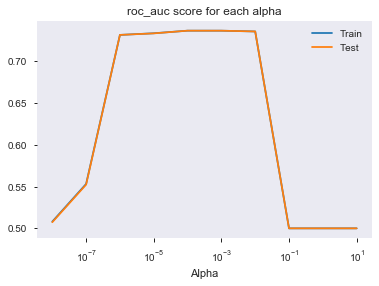

In [122]:
plt.plot(param_grid['alpha'], model.cv_results_['mean_train_score'], label='Train')
plt.plot(param_grid['alpha'], model.cv_results_['mean_test_score'], label='Test')
plt.xscale('log')
plt.grid()
plt.title('roc_auc score for each alpha')
plt.xlabel('Alpha')
plt.legend() 
plt.show()

In [123]:
confusion_matrix(y_cv, y_pred)

array([[1846219,    5316],
       [ 110843,    3627]], dtype=int64)

In [124]:
final_pred = cccv_lr_model.predict_proba(X_test_standardized)
test_data['pred_proba'] = final_pred[:,1]

In [125]:
test_sub = pd.merge(test['impression_id'], 
                    test_data[['impression_id', 'pred_proba']].groupby('impression_id').agg(['mean']),
                    on='impression_id', how='inner')

In [126]:
test_sub.columns = ['impression_id', 'is_click']
test_sub.to_csv('Submission.csv', index=False)

### LGBMClassifier

In [127]:
import lightgbm as lgb
fit_params={
            "early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_cv,y_cv)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'
            }

In [128]:
param_test={
            'learning_rate': [0.01, 0.05, 0.1, 0.5],
             'n_estimators': sp_randint(10, 150),
             'max_depth': sp_randint(3, 50),
             'num_leaves': sp_randint(6, 40),
             'bagging_fraction': [0.2, 0.5, 0.8],
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 10, 50, 100, 200, 300],
             'reg_lambda': [0, 1e-1, 1, 10, 50, 100, 200, 300],
             #'lambda_l1': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'lambda_l2': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4] 
            }

In [129]:
LGBM_clf = lgb.LGBMClassifier(random_state=314, silent=True, metric='None', #feval=evalerror,
                              #weight=(0.0001,0.9999), 
                              n_jobs=6)
LGBM_clf_rscv = RandomizedSearchCV(estimator=LGBM_clf, 
                        param_distributions=param_test, 
                        n_iter=20,
                        scoring='roc_auc',
                        cv=StratifiedKFold(n_splits=3,random_state=42, shuffle=True),
                        refit=True, random_state=314, verbose=1, n_jobs=-1)

In [130]:
LGBM_clf_rscv.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(LGBM_clf_rscv.best_score_, LGBM_clf_rscv.best_params_))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 25.2min finished


Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.745229
Did not meet early stopping. Best iteration is:
[105]	valid's auc: 0.745345
Best score reached: 0.7449635991164448 with params: {'bagging_fraction': 0.5, 'colsample_bytree': 0.7843976983964338, 'lambda_l2': 1e-05, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 245, 'min_child_weight': 0.1, 'n_estimators': 110, 'num_leaves': 33, 'reg_alpha': 10, 'reg_lambda': 300, 'subsample': 0.7211475201828479} 


In [131]:
best_params = LGBM_clf_rscv.best_params_

In [132]:
LGBM_clf_final = lgb.LGBMClassifier(**LGBM_clf.get_params())
#set optimal parameters
LGBM_clf_final.set_params(**best_params)
LGBM_clf_final.fit(X_train, y_train, **fit_params)

Training until validation scores don't improve for 30 rounds.
[100]	valid's auc: 0.745229
Did not meet early stopping. Best iteration is:
[105]	valid's auc: 0.745345


LGBMClassifier(bagging_fraction=0.5, boosting_type='gbdt', class_weight=None,
        colsample_bytree=0.7843976983964338, importance_type='split',
        lambda_l2=1e-05, learning_rate=0.1, max_depth=10, metric='None',
        min_child_samples=245, min_child_weight=0.1, min_split_gain=0.0,
        n_estimators=110, n_jobs=6, num_leaves=33, objective=None,
        random_state=314, reg_alpha=10, reg_lambda=300, silent=True,
        subsample=0.7211475201828479, subsample_for_bin=200000,
        subsample_freq=0)

In [133]:
y_pred = LGBM_clf_final.predict(X_cv)

y_pred_proba = LGBM_clf_final.predict_proba(X_cv)

print("Accuracy :",accuracy_score(y_cv, y_pred))
print("ROC_AUC :",roc_auc_score(y_cv, y_pred_proba[:,1]))
print("f1_score :",f1_score(y_cv, y_pred))
print("Hamming loss ",hamming_loss(y_cv,y_pred))
print("Log loss ",log_loss(y_cv,y_pred))

print (classification_report(y_cv, y_pred))

Accuracy : 0.9419040134689383
ROC_AUC : 0.7453446331872765
f1_score : 0.009315558022742452
Hamming loss  0.058095986531061725
Log loss  2.0065644037442367
              precision    recall  f1-score   support

           0       0.94      1.00      0.97   1851535
           1       0.65      0.00      0.01    114470

   micro avg       0.94      0.94      0.94   1966005
   macro avg       0.80      0.50      0.49   1966005
weighted avg       0.93      0.94      0.91   1966005



In [134]:
confusion_matrix(y_cv, y_pred)

array([[1851251,     284],
       [ 113933,     537]], dtype=int64)

In [76]:
final_pred = LGBM_clf_final.predict_proba(test_data.iloc[:,1:-1])
test_data['pred_proba'] = final_pred[:,1]

In [81]:
del test_sub
gc.collect()

468

In [82]:
test_sub = pd.merge(test['impression_id'], 
                    test_data[['impression_id', 'pred_proba']].groupby('impression_id').agg(['mean']),
                    on='impression_id', how='inner')

In [83]:
test_sub.columns = ['impression_id', 'is_click']
test_sub.to_csv('Submission.csv', index=False)